# **Summary**
This notebook will include a baseline model using the **cleaned dataset from the notebook "EDA.ipynb"**. This baseline model will use a cleaned dataset that has *not* been preprocessed (with the exception of one-hot encoding categorical features) and will be fitted onto a simple model, **logistic regression** that establishes a simple, interpretable starting point for predicting employee turnover (Termd). It helps to set a performance benchmark for comparison with more complex models (e.g., Random Forest).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

pd.set_option('display.max_columns', None)
df = pd.read_csv("cleaned_HRDataset.csv")
df.shape

(311, 44)

In [2]:
col_drop = ['EmpID', 'Employee_Name', 'DOB', 'Zip', 'State', 'DateofHire', 'DateofTermination', 'LastPerformanceReview_Date',
            'TermReason', 'EmploymentStatus', 'EmpStatusID']
df = df.drop(col_drop, axis=1)

df.head(2)

,MarriedID,MaritalStatusID,GenderID,DeptID,PerfScoreID,FromDiversityJobFairID,Salary,Termd,PositionID,Position,Sex,MaritalDesc,CitizenDesc,HispanicLatino,RaceDesc,Department,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,DaysLateLast30,Absences,Age,Tenure,DiversityStatus,DeptAverageSalary,Salary_Dept_Ratio,DeptAveragePerfScore,PerformanceStandard,DaysSinceLastReview
0,0,0,1,5,4,0,62506,0,19,Production Technician I,M,Single,US Citizen,No,White,Production,Michael Albert,22.0,LinkedIn,Exceeds,4.60,5,0,0,1,36,8.490075,Non-Diverse,59967.788462,1.042326,2.980769,1,348
1,1,1,1,3,3,0,104437,1,27,Sr. DBA,M,Married,US Citizen,No,White,IT/IS,Simon Roup,4.0,Indeed,Fully Meets,4.96,3,6,0,17,44,1.215606,Non-Diverse,97064.640000,1.075953,3.060000,0,113


## **1. Setting up Model**

In [3]:
X = df.drop('Termd', axis=1)
y = df['Termd']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

In [4]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ])

logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

## **2. Train & Predict**

In [5]:
logreg_pipeline.fit(X_train, y_train)

y_pred = logreg_pipeline.predict(X_test)
y_proba = logreg_pipeline.predict_proba(X_test)[:, 1]

## **3. Evaluate**

In [6]:
def model_metrics(preds, y):
    print(f'Accuracy: {accuracy_score(preds, y)}')
    print(f'Precision: {precision_score(preds, y)}')
    print(f'Recall: {recall_score(preds, y)}')
    print(f'F1: {f1_score(preds, y)}')
    print(f'ROC_AUC: {roc_auc_score(preds, y)}')

model_metrics(y_pred, y_test)

Accuracy: 0.6666666666666666
Precision: 0.38095238095238093
Recall: 0.5
F1: 0.43243243243243246
ROC_AUC: 0.6117021276595744


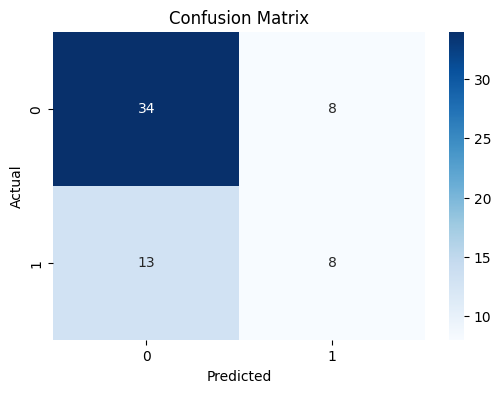

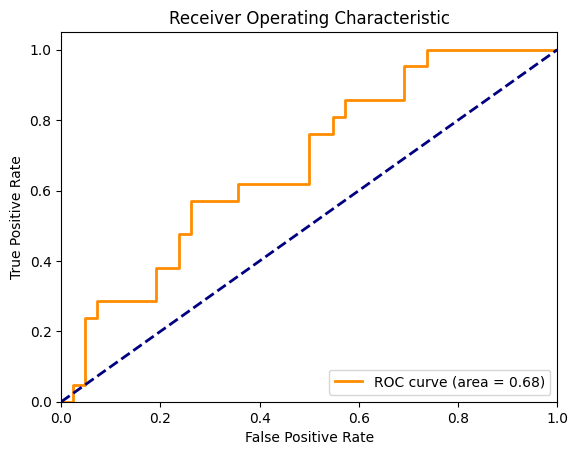

In [7]:
# Confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [8]:
try:
    cat_features = (logreg_pipeline.named_steps['preprocessor']
                   .named_transformers_['cat']
                   .get_feature_names_out(categorical_cols))

    num_features = numerical_cols
    feature_names = np.concatenate([cat_features, num_features])
    coefficients = logreg_pipeline.named_steps['classifier'].coef_[0]

    if len(feature_names) != len(coefficients):
        print(f"Warning: {len(feature_names)} features vs {len(coefficients)} coefficients")
        feature_names = feature_names[:len(coefficients)]

    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

    print("\nTop Predictive Features:")
    print(coef_df.head(10))

except Exception as e:
    print(f"Error generating coefficients: {str(e)}")


Top Predictive Features:
                                 Feature  Coefficient
71                ManagerName_Simon Roup     1.448701
53                  ManagerName_Amy Dunn     1.325245
76       RecruitmentSource_Google Search     0.844784
74  RecruitmentSource_Diversity Job Fair     0.790840
84    PerformanceScore_Needs Improvement     0.765089
73       RecruitmentSource_CareerBuilder     0.760186
20     Position_Production Technician II     0.655299
9        Position_Database Administrator     0.649474
35                   MaritalDesc_Widowed     0.641515
72            ManagerName_Webster Butler     0.628914


## **4. Conclusion**
The baseline model has **moderate performance (Accuracy: 67%, ROC AUC: 0.61)**, indicating the model is correctly classifying about 67% of the instances and there is room for improvement.

A **precision of 0.38** means that only 38% of instances predicted as positive by the model are actually positive. Additionally, a **recall of 0.5** means that model is correctly identifying 50% of the actual positive instances. The model is missing half of the true positives.

This model is dealing with a class imbalance, indicating the F1-score is a more accurate metric of how the model is performing. The **f1-score of 0.43** indicates the model is not doing well balancing the precision and recall as seen above.

**Overall, the model has a moderate accuracy but is struggling with positive class prediction.** Potential improvement by:

- **Feature selection/engineering** to reduce dimensionality and address multicollinearity
- **Address class imbalance**

**Important Features:**
- **1. Manager Impact:**
  - Employees under Simon Roup, Amy Dunn, and Webster Butler show significantly higher turnover risk.
  - Investigate managerial practices/team dynamics for these leaders.
- **2. Recruitment Source:**
  - Hires from Google Search and Diversity Job Fairs correlate with turnover.
- **3. Performance & Role Risks:**
  - Employees in "Needs Improvement" performance category and roles like Production Technician II are higher risk.
  - Target retention efforts (training programs) for those department and positions.